In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import quack.schedule.multi_qubit as sims
import importlib
import pickle

## Two qubit LZ, linear sweep

In [23]:
importlib.reload(sims);
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = sims.Coupler(i_sigma, c_sigma, lc, d)

elements = [qubit0, coupler01, qubit1]

# couple qubits in a chain
m = 65; m_mat = np.zeros((3, 3));
m_mat[0, 1] = m; m_mat[1, 2] = m;
m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([7, 4, 7])

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [11]:
hz = 0.8*2*np.pi
lamb = 0.2;
hx = hz*lamb

gamma_L = lambda s: 2*s - 1

schedule_dict_l = {}; pts = 30;
s = np.linspace(0, 1, pts)
schedule_dict_l["points"] = pts

schedule_dict_l["x_0"] = hx*np.ones(pts)
schedule_dict_l["x_1"] = hx*np.ones(pts)

schedule_dict_l["z_0"] = hz*gamma_L(s)
schedule_dict_l["z_1"] = np.zeros(pts)

schedule_dict_l["zz_0,1"] = -hz*np.ones(pts)

In [25]:
%%time

custom_flux_dict_num = circuit.get_custom_fluxes_num(schedule_dict_l, verbose=True, optimizer_method="leastsq")

CPU times: user 1h 14min 53s, sys: 1h 13min 18s, total: 2h 28min 11s
Wall time: 20min 43s


In [26]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(schedule_dict_l, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 2
calculating qubit biases for qubit 2 of 2
schedule point 30 / 30
 calculating coupler bias for coupler 1 of 1
CPU times: user 37min, sys: 36min 31s, total: 1h 13min 32s
Wall time: 9min 28s


In [27]:
with open('./data/circuit_LZ_linear.pkl', 'wb') as file:
    pickle.dump(circuit, file)

In [28]:
%%time

ising_sw_from_num = circuit.get_ising_sw(custom_flux_dict_num, verbose=True)
ising_sw_from_pwsw = circuit.get_ising_sw(custom_flux_dict_pwsw, verbose=True)

CPU times: user 6min 9s, sys: 5min 59s, total: 12min 8s
Wall time: 1min 50s


In [29]:
%%time
e_circuit = circuit.calculate_spectrum(custom_flux_dict_num, levels=6)

CPU times: user 53.7 s, sys: 52.3 s, total: 1min 45s
Wall time: 8.91 s


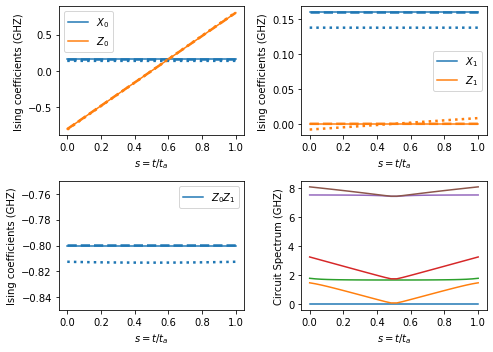

In [30]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 5))

for i in range(2):
    ax1 = plt.subplot(2, 2, i+1)
    
    plt.plot(s, schedule_dict_l["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, schedule_dict_l["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")

    plt.plot(s, ising_sw_from_num["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_sw_from_num["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s, ising_sw_from_pwsw["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
for i in range(1):
    ax2 = plt.subplot(2, 2, i+3)
    
    plt.plot(s, schedule_dict_l["zz_"+str(i)+str(i+1)]/2/np.pi, label=r"$Z_{0:d}Z_{1:d}$".format(i, i+1))
    
    plt.plot(s, ising_sw_from_num["zz_"+str(i)+str(i+1)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["zz_"+str(i)+str(i+1)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
    plt.ylim(-0.85, -0.75)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 4)
plt.plot(s, e_circuit/2/np.pi)
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Circuit Spectrum (GHZ)")
    
plt.tight_layout()
# plt.savefig("./plots/LZ_linear.pdf", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


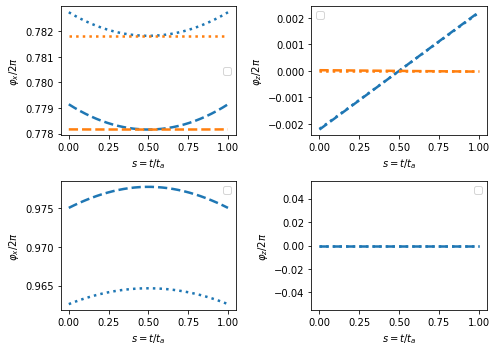

In [31]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 5))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
# plt.savefig("./plots/fluxes.pdf", bbox_inches="tight")
plt.show()

## Two qubit LZ, Grover sweep

In [41]:
importlib.reload(sims);
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = sims.Coupler(i_sigma, c_sigma, lc, d)

elements = [qubit0, coupler01, qubit1]

# couple qubits in a chain
m = 65; m_mat = np.zeros((3, 3));
m_mat[0, 1] = m; m_mat[1, 2] = m;
m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([7, 4, 7])

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [12]:
hz = 0.8*2*np.pi
lamb = 0.2;
hx = hz*lamb

gamma_G = lambda s, lamb: (1/(np.sqrt(lamb**(-4)-1)))*np.tan((2*s-1)*np.arctan(np.sqrt(lamb**(-4)-1)))

schedule_dict_g = {}; pts = 40;
s = np.linspace(0, 1, pts)
schedule_dict_g["points"] = pts

schedule_dict_g["x_0"] = hx*np.ones(pts)
schedule_dict_g["x_1"] = hx*np.ones(pts)

schedule_dict_g["z_0"] = hz*gamma_G(s, lamb)
schedule_dict_g["z_1"] = np.zeros(pts)

schedule_dict_g["zz_0,1"] = -hz*np.ones(pts)

In [11]:
%%time

custom_flux_dict_num = circuit.get_custom_fluxes_num(schedule_dict_g, verbose=True, optimizer_method="leastsq")

CPU times: user 2h 5min 33s, sys: 1h 54min 29s, total: 4h 2s
Wall time: 33min 51s


In [12]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(schedule_dict_g, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 2
calculating qubit biases for qubit 2 of 2
schedule point 40 / 40
 calculating coupler bias for coupler 1 of 1
CPU times: user 51min 22s, sys: 38min 26s, total: 1h 29min 49s
Wall time: 11min 48s


In [22]:
with open('./data/circuit_LZ_grover.pkl', 'wb') as file:
    pickle.dump(circuit, file)

In [13]:
%%time

ising_sw_from_num = circuit.get_ising_sw(custom_flux_dict_num, verbose=True)
ising_sw_from_pwsw = circuit.get_ising_sw(custom_flux_dict_pwsw, verbose=True)

CPU times: user 7min 14s, sys: 6min 59s, total: 14min 13s
Wall time: 2min 2s


In [14]:
%%time
e_circuit = circuit.calculate_spectrum(custom_flux_dict_num, levels=6)

CPU times: user 1min 11s, sys: 1min 13s, total: 2min 25s
Wall time: 12.3 s


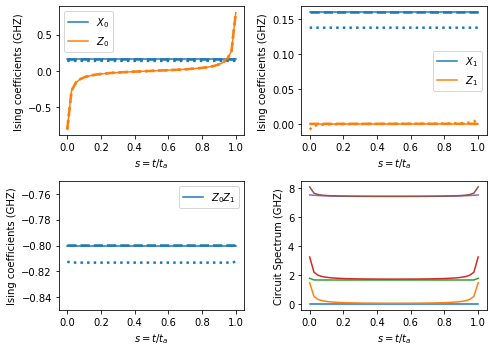

In [20]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 5))

for i in range(2):
    ax1 = plt.subplot(2, 2, i+1)
    
    plt.plot(s, schedule_dict_g["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, schedule_dict_g["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")

    plt.plot(s, ising_sw_from_num["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_sw_from_num["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s, ising_sw_from_pwsw["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
for i in range(1):
    ax2 = plt.subplot(2, 2, i+3)
    
    plt.plot(s, schedule_dict_g["zz_"+str(i)+str(i+1)]/2/np.pi, label=r"$Z_{0:d}Z_{1:d}$".format(i, i+1))
    
    plt.plot(s, ising_sw_from_num["zz_"+str(i)+str(i+1)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["zz_"+str(i)+str(i+1)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
    plt.ylim(-0.85, -0.75)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 4)
plt.plot(s, e_circuit/2/np.pi)
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Circuit Spectrum (GHZ)")
    
plt.tight_layout()
# plt.savefig("./plots/LZ_grover.pdf", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


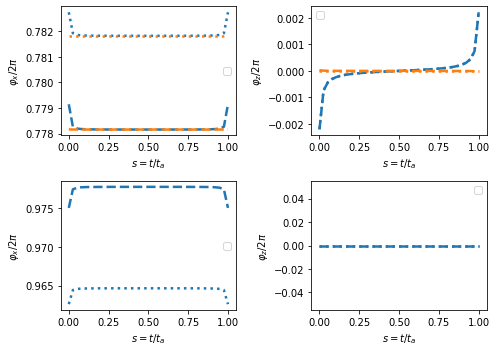

In [16]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 5))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5)
    plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
# plt.savefig("./plots/fluxes.pdf", bbox_inches="tight")
plt.show()

## LZ linear and grover together

In [2]:
with open('./data/circuit_LZ_linear.pkl', 'rb') as file:
    circuit_l = pickle.load(file)

with open('./data/circuit_LZ_grover.pkl', 'rb') as file:
    circuit_g = pickle.load(file)

In [3]:
s_l = np.linspace(0, 1, circuit_l.custom_flux_num["points"])
s_g = np.linspace(0, 1, circuit_g.custom_flux_num["points"])

In [4]:
%%time

ising_sw_from_num_l = circuit_l.get_ising_sw(circuit_l.custom_flux_num, verbose=True)
ising_sw_from_pwsw_l = circuit_l.get_ising_sw(circuit_l.custom_flux_pwsw, verbose=True)
e_circuit_l = circuit_l.calculate_spectrum(circuit_l.custom_flux_num, levels=6)

CPU times: user 6min 38s, sys: 6min 37s, total: 13min 16s
Wall time: 1min 46s


In [6]:
%%time

ising_sw_from_num_g = circuit_g.get_ising_sw(circuit_g.custom_flux_num, verbose=True)
ising_sw_from_pwsw_g = circuit_g.get_ising_sw(circuit_g.custom_flux_pwsw, verbose=True)
e_circuit_g = circuit_g.calculate_spectrum(circuit_g.custom_flux_num, levels=6)

CPU times: user 8min 29s, sys: 8min 23s, total: 16min 53s
Wall time: 2min 16s


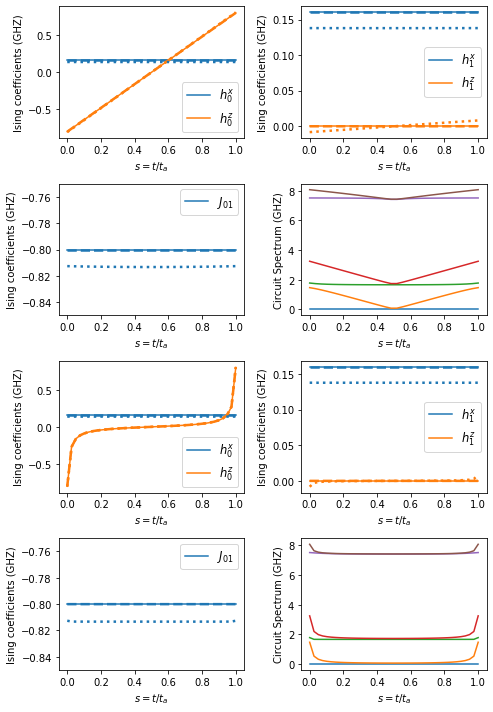

In [15]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 10))

for i in range(2):
    ax1 = plt.subplot(4, 2, i+1)
    
    plt.plot(s_l, schedule_dict_l["x_"+str(i)]/2/np.pi, label=r"$h^x_{0:d}$".format(i), color="C0")
    plt.plot(s_l, schedule_dict_l["z_"+str(i)]/2/np.pi, label=r"$h^z_{0:d}$".format(i), color="C1")

    plt.plot(s_l, ising_sw_from_num_l["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s_l, ising_sw_from_num_l["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s_l, ising_sw_from_pwsw_l["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s_l, ising_sw_from_pwsw_l["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
for i in range(1):
    ax2 = plt.subplot(4, 2, i+3)
    
    plt.plot(s_l, schedule_dict_l["zz_"+str(i)+','+str(i+1)]/2/np.pi, label=r"$J_{{{0:d}{1:d}}}$".format(i, i+1))
    
    plt.plot(s_l, ising_sw_from_num_l["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s_l, ising_sw_from_pwsw_l["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
    plt.ylim(-0.85, -0.75)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
ax3 = plt.subplot(4, 2, 4)
plt.plot(s_l, e_circuit_l/2/np.pi)
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Circuit Spectrum (GHZ)")

for i in range(2):
    ax1 = plt.subplot(4, 2, i+5)
    
    plt.plot(s_g, schedule_dict_g["x_"+str(i)]/2/np.pi, label=r"$h^x_{0:d}$".format(i), color="C0")
    plt.plot(s_g, schedule_dict_g["z_"+str(i)]/2/np.pi, label=r"$h^z_{0:d}$".format(i), color="C1")

    plt.plot(s_g, ising_sw_from_num_g["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s_g, ising_sw_from_num_g["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s_g, ising_sw_from_pwsw_g["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s_g, ising_sw_from_pwsw_g["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
for i in range(1):
    ax2 = plt.subplot(4, 2, i+7)
    
    plt.plot(s_g, schedule_dict_g["zz_"+str(i)+','+str(i+1)]/2/np.pi, label=r"$J_{{{0:d}{1:d}}}$".format(i, i+1))
    
    plt.plot(s_g, ising_sw_from_num_g["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s_g, ising_sw_from_pwsw_g["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
    plt.ylim(-0.85, -0.75)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
ax3 = plt.subplot(4, 2, 8)
plt.plot(s_g, e_circuit_g/2/np.pi)
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Circuit Spectrum (GHZ)")
    
plt.tight_layout()
# plt.savefig("./plots/LZ_schedules.pdf", bbox_inches="tight")
plt.show()